# CRAN network evolution

In [1]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt




#### **Utilities**

In [2]:
import os
from time import time
import networkx as nx
import matplotlib.pyplot as plt
import psutil

def add_chunk(
    df, G, dependent_field, dependency_field,
    filter_field=None,
    filter_value=None
):
    """ Utility method for build_dependency_network"""
    filtered = df[df[filter_field] == filter_value] if filter_field else df
    links = list(zip(filtered[dependency_field], filtered[dependent_field]))
    G.add_edges_from(links)
    return G

def build_dependency_network(
    df,
    chunk_size,
    dependent_field: str = 'Project Name',
    dependency_field: str = 'Dependency Name',
    filter_field=None,
    filter_value=None,
    verbose: bool = True
):
    # Print only if verbose
    vprint = print if verbose else lambda *a, **k: None
    process = psutil.Process(os.getpid())
    vprint("Using process ", process)
    t = time()
    try:
        vprint('Initializing graph... ', end='')
        # New NetworkX directed Graph
        G = nx.DiGraph()
        vprint('OK')
        
        # Split DataFrame into chunks
        chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
        
        for i, chunk in enumerate(chunks):
            # Add dependencies from chunk to G
            add_chunk(
                chunk, 
                G,
                dependent_field=dependent_field,
                dependency_field=dependency_field,
                filter_field=filter_field,
                filter_value=filter_value
            )
            vprint(f'{round(i*chunk_size/1e6,1)}M lines | {len(G)} nodes, {len(G.edges)} deps. ({int(time()-t)}s) {round(process.memory_info().rss/1e6,1)}Mb')
        vprint('Done processing DataFrame')
        
        # IMPORTANT: Reverse the graph to get the correct dependencies
        return G.reverse(copy=True)
    
    except Exception as e:
        print('\n', e)

def plot_degree_distribution(G, title, color):
    '''
    Plot the degree distribution of a networkx graph
    '''

    # Nodes' degree vector
    degree=[x[1] for x in G.degree()]
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot histogram without log scale
    axs[0].hist(degree, color=color)
    axs[0].set_title(title)
    axs[0].set_xlabel('Degree')
    axs[0].set_ylabel('Number of nodes')
    
    # Plot histogram with log scale
    axs[1].hist(degree, bins=100, color=color)
    axs[1].set_title(f"{title} in log scale")
    axs[1].set_xlabel('Degree')
    axs[1].set_ylabel('Number of nodes')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    
    plt.show()

def draw_networkx_graph(G, layout='circular', size=(20,20)):
    '''
    Draw a networkx graph
    '''

    layouts = {
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spring': nx.spring_layout,
        'spectral': nx.spectral_layout,
        'random': nx.random_layout,
    }
    plt.figure(figsize=size)
    pos = layouts[layout](G)
    node_size = [G.in_degree(node) * 80 for node in G]
    node_color = [G.in_degree(node) for node in G]
    edge_color = 'black'
    width = 1
    nx.draw_networkx(G, pos=pos, node_size=node_size, node_color=node_color, alpha=0.7,
                     with_labels=False, edge_color=edge_color, width=width)
    
    # Agregar etiquetas personalizadas
    labels = {node: node for node in G.nodes()}
    node_labels = nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=8,
                                          font_weight='bold', bbox=dict(facecolor='red', edgecolor='none', pad=0.3))

    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()

def draw_package_deep_network(G, package_name, deep, size=(10, 10), layout='spring', title=None):
    '''
    Draw the subgraph of a package and its dependencies up to a certain depth.

    '''

    layouts = {
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spring': nx.spring_layout,
        'spectral': nx.spectral_layout,
    }

    # Create a subgraph of the package and its dependencies up to a certain depth
    # subgraph = nx.ego_graph(G, package_name, radius=deep, center=True)
    subgraph = nx.ego_graph(G, package_name, radius=deep, center=True)

    # Draw the subgraph
    plt.figure(figsize=size)
    pos = layouts[layout](subgraph)
    node_size = [subgraph.in_degree(node) * 100 for node in subgraph]
    node_color = [subgraph.in_degree(node) for node in subgraph]
    edge_color = 'black'
    width = 1
    nx.draw_networkx(subgraph, pos=pos, node_size=node_size, node_color=node_color, alpha=0.7,
                        with_labels=False, edge_color=edge_color, width=width)
    
    # Add title
    if title:
        plt.title(title, fontsize=16, fontweight='bold')


    # Set target node square in blue
    nx.draw_networkx_nodes(subgraph, pos=pos, nodelist=[package_name], node_size=100, node_color='blue', alpha=0.7)

    # Add custom labels
    labels = {node: node for node in subgraph.nodes()}
    nx.draw_networkx_labels(
        subgraph, pos=pos, labels=labels, font_size=8,
        font_weight='bold', bbox=dict(facecolor='red', edgecolor='none', pad=0.3)
    )
    
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()

    return subgraph



def calculate_network_metrics(G):
    # Ordenar los nodos por grado en orden descendente
    sorted_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)

    # Tomar los top 10 nodos por grado
    top_nodes = [node for node, _ in sorted_nodes[:10]]

    # Calcular las métricas de red para los nodos principales
    metrics = {}
    
    # Grado de los nodos principales (in-degree y out-degree)
    metrics['In-degree'] = {node: G.in_degree(node) for node in top_nodes}
    metrics['Out-degree'] = {node: G.out_degree(node) for node in top_nodes}
    print("In-degree y Out-degree OK")

    # Centralidad de intermediación de los nodos principales
    betweenness_centrality = nx.betweenness_centrality(G)
    metrics['Betweenness Centrality'] = {node: betweenness_centrality[node] for node in top_nodes}
    print("Betweenness Centrality OK")

    # Centralidad de cercanía de los nodos principales
    closeness_centrality = nx.closeness_centrality(G)
    metrics['Closeness Centrality'] = {node: closeness_centrality[node] for node in top_nodes}
    print("Closeness Centrality OK")

    # Coeficiente de agrupamiento de los nodos principales
    clustering_coefficient = nx.clustering(G)
    metrics['Clustering Coefficient'] = {node: clustering_coefficient[node] for node in top_nodes}
    print("Clustering Coefficient OK")

    # PageRank de los nodos principales
    pagerank = nx.pagerank(G)
    metrics['PageRank'] = {node: pagerank[node] for node in top_nodes}
    print("PageRank OK")

    # Save metrics to a DataFrame
    metrics = pd.DataFrame(metrics)

    return metrics

def analyze_network_degree(graph):
    # Average degree of the network
    avg_degree = sum(dict(graph.degree()).values()) / len(graph)
    print(f"Average degree of the network:")
    print(avg_degree, "\n")

    # Top 10 most connected nodes (in-degree)
    mc_ind = sorted(graph.in_degree, key=lambda x: x[1], reverse=True)[:10]
    print(f"Top 10 most connected nodes (in-degree):")
    print(mc_ind, "\n")

    # Top 10 most connected nodes (out-degree)
    mc_out = sorted(graph.out_degree, key=lambda x: x[1], reverse=True)[:10]
    print(f"Top 10 most connected nodes (out-degree):")
    print(mc_out, "\n")

    # Top 10 least connected nodes (in-degree) if degree is >= 1
    lc_ind = sorted(graph.in_degree, key=lambda x: x[1])[:10]
    print("Top 10 least connected nodes (in-degree):")
    print(lc_ind, "\n")

    # Top 10 least connected nodes (out-degree)
    lc_out = sorted(graph.out_degree, key=lambda x: x[1])[:10]
    print("Top 10 least connected nodes (out-degree):")
    print(lc_out, "\n")


## Data processing

### Librariesio network data analysis

**1 - Visualization of librariesio DataSet**

In [3]:
# Load librariesio csv file
librariesio_df = pd.read_csv('../olivia_finder/results/csv_datasets/cran/cran_adjlist_librariesio.csv')

# Remove not necessary columns
librariesio_df = librariesio_df.drop(
    columns=[
        'ID', 
        'Platform', 
        'Project ID', 
        'Version ID', 
        'Dependency Platform', 
        'Optional Dependency', 
        'Dependency Requirements', 
        'Dependency Project ID'
    ]
)

# Saw number of rows and columns
initial_rows = librariesio_df.shape[0]
print("Dataframe shape: ", librariesio_df.shape)
librariesio_df.head(10)

Dataframe shape:  (520065, 4)


,Project Name,Version Number,Dependency Name,Dependency Kind
0,nmfem,1.0.0,R,depends
1,nmfem,1.0.0,plyr,imports
2,nmfem,1.0.0,dplyr,imports
3,nmfem,1.0.0,d3heatmap,imports
4,nmfem,1.0.0,mixtools,imports
5,nmfem,1.0.0,tidyr,imports
6,nmfem,1.0.0,knitr,suggests
7,nmfem,1.0.0,testthat,suggests
8,nmfem,1.0.0,rmarkdown,suggests
9,nmfem,1.0.1,R,depends


**2 - Collection of versions for the same package**

One of the things we notice is that there are data entries for different versions of the same package. Let's show an example.

In [4]:
# Sow nmfem package
librariesio_df[librariesio_df['Project Name'] == 'nmfem']

,Project Name,Version Number,Dependency Name,Dependency Kind
0,nmfem,1.0.0,R,depends
1,nmfem,1.0.0,plyr,imports
2,nmfem,1.0.0,dplyr,imports
3,nmfem,1.0.0,d3heatmap,imports
4,nmfem,1.0.0,mixtools,imports
5,nmfem,1.0.0,tidyr,imports
6,nmfem,1.0.0,knitr,suggests
7,nmfem,1.0.0,testthat,suggests
8,nmfem,1.0.0,rmarkdown,suggests
9,nmfem,1.0.1,R,depends


To solve this issue, we will only consider the most recent version of the package.

Let's observe the format that these version numbers take:

In [5]:
# Show librariesio_df dataframe unique values at column 'Version Number'
print("Unique values at column 'Version Number': ", librariesio_df['Version Number'].unique())
print("Total:",len(librariesio_df['Version Number'].unique()))

Unique values at column 'Version Number':  ['1.0.0' '1.0.1' '1.0.2' ... '0.8.0.0' '0.91.1' '8.0.0']
Total: 8624


Assuming that the dataset is sorted with packages in ascending order of version, we generate a package-version dictionary that associates each package with the latest updated version.

In [6]:
package_version = {}

# Loop all the rows
for index, row in tqdm.tqdm(librariesio_df.iterrows(), total=librariesio_df.shape[0]):
    # Get the version number
    version_number = row['Version Number']
    # Get the project name
    project_name = row['Project Name']

    if project_name not in package_version:
        package_version[project_name] = version_number
    else:
        if version_number != package_version[project_name]:
            package_version[project_name] = version_number


  0%|          | 0/520065 [00:00<?, ?it/s]

100%|██████████| 520065/520065 [00:24<00:00, 21450.06it/s]


In [7]:
# Show the dictionary
package_version["nmfem"]

'1.0.4'

In [8]:
# Identify the rows to keep
mask = librariesio_df['Version Number'] == librariesio_df['Project Name'].map(package_version)

# Filter the dataframe
librariesio_df = librariesio_df[mask]

The result is a filtered dataset, removing package duplicity for different version numbers.

In [9]:
# Sow nmfem package
librariesio_df[librariesio_df['Project Name'] == 'nmfem']

,Project Name,Version Number,Dependency Name,Dependency Kind
36,nmfem,1.0.4,rmarkdown,suggests
37,nmfem,1.0.4,testthat,suggests
38,nmfem,1.0.4,knitr,suggests
39,nmfem,1.0.4,tidyr,imports
40,nmfem,1.0.4,mixtools,imports
41,nmfem,1.0.4,d3heatmap,imports
42,nmfem,1.0.4,dplyr,imports
43,nmfem,1.0.4,plyr,imports
44,nmfem,1.0.4,R,depends


In total, the data processing yields the following statistics:

In [10]:
final_rows = librariesio_df.shape[0]

print("Initial rows: ", initial_rows)
print("Final rows: ", final_rows)
print("Rows removed: ", initial_rows - final_rows)

Initial rows:  520065
Final rows:  107794
Rows removed:  412271


**3 - Librariesio "Dependency Kind" field**

As you can see, the libraries.io dataset includes a lot of irrelevant information. That's why we're going to clean it up to get a better visualization of the data.

One of the first things we notice is the "Dependency Kind" field. This field indicates the type of dependency that a particular package is. This classification is specific to the R programming language.

There are different types:


In [11]:
# Obtener los distintos tipos de "Dependency Kind"
librariesio_df['Dependency Kind'].unique().tolist()

['suggests', 'imports', 'depends', 'enhances']

- **Imports**: Indicates the packages that are necessary for the package to function correctly. The package that declares "Imports" depends on the functions and objects provided by these packages. Additionally, these packages are automatically installed when the main package is installed.

- **Depends**: Similar to "Imports" in that it specifies packages necessary for the proper functioning of the package. However, dependencies declared in "Depends" have an even stronger relationship with the main package. This means that the main package cannot function without the dependencies declared in "Depends". These packages are also automatically installed along with the main package.

- **Suggests**: These are packages that are suggested to be installed alongside the main package, but they are not necessary for its basic functionality. These packages are considered useful and can provide additional features or enhance the user experience. However, they are not automatically installed with the main package.

- **Enhances**: Similar to "Suggests", packages mentioned in "Enhances" are suggested to enhance the main package, but they are not necessary for its basic functionality. The difference is that the packages listed in "Enhances" are considered more significant and specific improvements for certain use cases. These packages are also manually installed.

In summary, "Imports" and "Depends" indicate the necessary dependencies for the package to function, while "Suggests" and "Enhances" provide optional recommendations to improve or expand the functionality of the package.

By removing "suggests" and "enhances", we significantly reduce the dataset.

In [12]:
# remove dependencies that are "suggests" and "enhances"
librariesio_df = librariesio_df[librariesio_df['Dependency Kind'] != 'suggests']
librariesio_df = librariesio_df[librariesio_df['Dependency Kind'] != 'enhances']
print(librariesio_df.shape)

(76474, 4)


In [13]:
print("Unique values at column 'Project Name': ", len(librariesio_df['Project Name'].unique()))

Unique values at column 'Project Name':  15154


### Scraped network data analysis

**1 - Visualization of scraped dataset**

In [14]:
scraped_df = pd.read_csv('../olivia_finder/results/csv_datasets/cran/cran_adjlist_scraping.csv')
# Remove colunmn version
scraped_df = scraped_df.drop(columns=['url'])
print(scraped_df.shape)
scraped_df.head()


(113276, 4)


,name,version,dependency,dependency_version
0,A3,1.0.0,R,≥ 2.15.0
1,A3,1.0.0,xtable,NaN
2,A3,1.0.0,pbapply,NaN
3,AATtools,0.0.2,R,≥ 3.6.0
4,AATtools,0.0.2,magrittr,NaN


As can be observed, this dataset contains 18,195 distinct packages.

In [15]:
# Number of rows with unique name values
print("Unique values at column 'name': ", len(scraped_df['name'].unique()))

Unique values at column 'name':  18195


## Comparation

### Packages evolution

By comparing the packages present in the different generated networks, we conclude that CRAN has been growing during this period of time (approximately 16%), and one-third of the existing packages have been replaced by others.

In [16]:
libraiesio_packages = librariesio_df['Project Name'].unique().tolist()
scraping_packages = scraped_df['name'].unique().tolist()
common_packages = list(set(libraiesio_packages) & set(scraping_packages))

print ("Packages in librariesio: ", len(libraiesio_packages))
print ("Packages in scraped: ", len(scraping_packages))
print ("Common packages: ", len(common_packages))
print("Packages in librariesio that are not in scraped: ", len(list(set(libraiesio_packages) - set(scraping_packages))))
print("Packages in scraped that are not in librariesio: ", len(list(set(scraping_packages) - set(libraiesio_packages))))

Packages in librariesio:  15154
Packages in scraped:  18195
Common packages:  11589
Packages in librariesio that are not in scraped:  3565
Packages in scraped that are not in librariesio:  6606


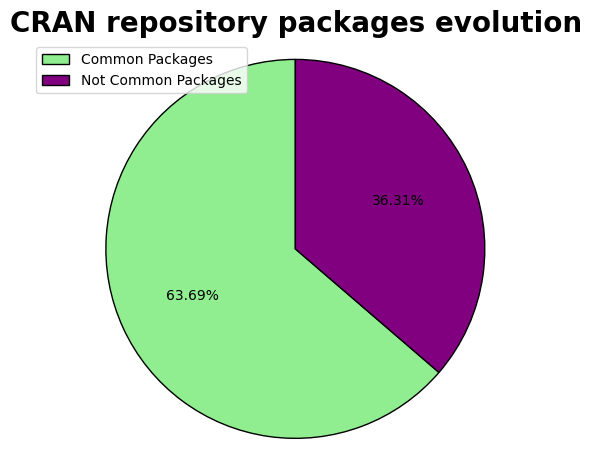

In [17]:
# Data for the graph
labels = ['Common Packages', 'Not Common Packages']
colors = ['lightgreen', 'purple']
sizes = [len(common_packages), len(list(set(scraping_packages) - set(libraiesio_packages)))]

# Customize the graph
fig, ax = plt.subplots()
ax.pie(sizes, autopct='%1.2f%%', startangle=90, colors=colors)
ax.set_aspect('equal')
ax.set_title('CRAN repository packages evolution', fontsize=20, fontweight='bold')

# add a black border to the pie

for pie_wedge in ax.patches:
    pie_wedge.set_edgecolor('black')

# Add legend
ax.legend(labels, loc='best')

# Improve aesthetics
plt.axis('equal')
plt.tight_layout()

# Display the graph
plt.show()

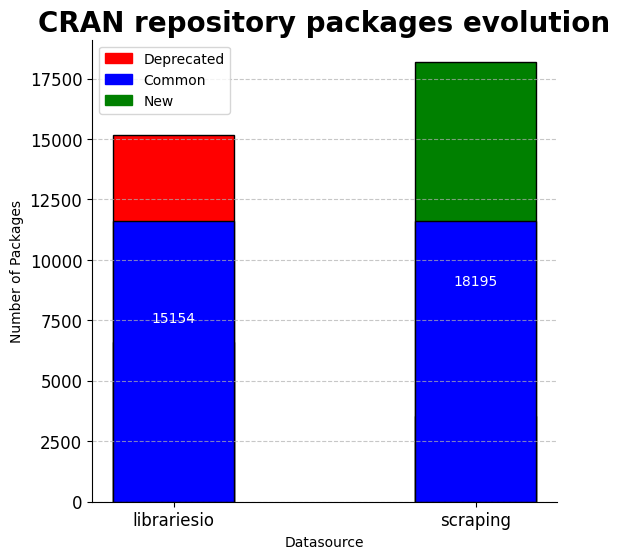

In [18]:
# Identifying common packages, exclusive to lista1, and exclusive to lista2
common_packages = list(set(libraiesio_packages) & set(scraping_packages))
new_packages = list(set(libraiesio_packages) - set(scraping_packages))
old_packages = list(set(scraping_packages) - set(libraiesio_packages))

# Configuring colors
colors_lista1 = ['red', 'blue']
colors_lista2 = ['green', 'blue']

# Heights of the bars
height_lista1 = len(libraiesio_packages)
height_lista2 = len(scraping_packages)

# Create the bar plot
fig, ax = plt.subplots(figsize=(6, 6))

# Bar for lista1
ax.bar('librariesio', height_lista1, color=colors_lista1, width=0.4, edgecolor='black')
ax.bar('librariesio', len(old_packages), color='red', width=0.4, edgecolor='black')
ax.bar('librariesio', len(common_packages), color='blue', width=0.4, edgecolor='black')

# Bar for lista2
ax.bar('scraping', height_lista2, color=colors_lista2, width=0.4, edgecolor='black')
ax.bar('scraping', len(new_packages), color='green', width=0.4, edgecolor='black')
ax.bar('scraping', len(common_packages), color='blue', width=0.4, edgecolor='black')

# Configure titles and axis labels
ax.set_title('CRAN repository packages evolution', fontsize=20, fontweight='bold')
ax.set_xlabel('Datasource')
ax.set_ylabel('Number of Packages')

# Add labels to the sections of the bar chart
ax.text(0, height_lista1 / 2, str(len(new_packages) + len(common_packages)), ha='center', va='center', color='white')
ax.text(1, height_lista2 / 2, str(len(old_packages) + len(common_packages)), ha='center', va='center', color='white')

# Add a horizontal grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjusting plot borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjusting tick labels font size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Configure legend
legend_labels = ['Deprecated', 'Common', 'New']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors_lista1 + ['green']]
ax.legend(legend_handles, legend_labels)

# Show the bar plot
plt.show()


### Network

We construct the networks to perform the analysis, using a directed network (A --> B, where B is a direct dependency of A).

In [19]:
# Libraries.io graph
librariesio_G = build_dependency_network(
    df = librariesio_df,
    chunk_size = 100000,
    dependent_field = 'Project Name',
    dependency_field = 'Dependency Name',
)

# Scraped graph
scraped_G = build_dependency_network(
    df = scraped_df,
    chunk_size = 100000,
    dependent_field = 'name',
    dependency_field = 'dependency',
)

Using process  psutil.Process(pid=69643, name='python', status='running', started='16:57:47')
Initializing graph... OK
0.0M lines | 15647 nodes, 76207 deps. (0s) 204.4Mb
Done processing DataFrame
Using process  psutil.Process(pid=69643, name='python', status='running', started='16:57:47')
Initializing graph... OK
0.0M lines | 17135 nodes, 99997 deps. (0s) 253.8Mb
0.1M lines | 18671 nodes, 113273 deps. (0s) 253.8Mb
Done processing DataFrame


**Degree distribution**

Regarding the degree distribution, no significant changes are observed.

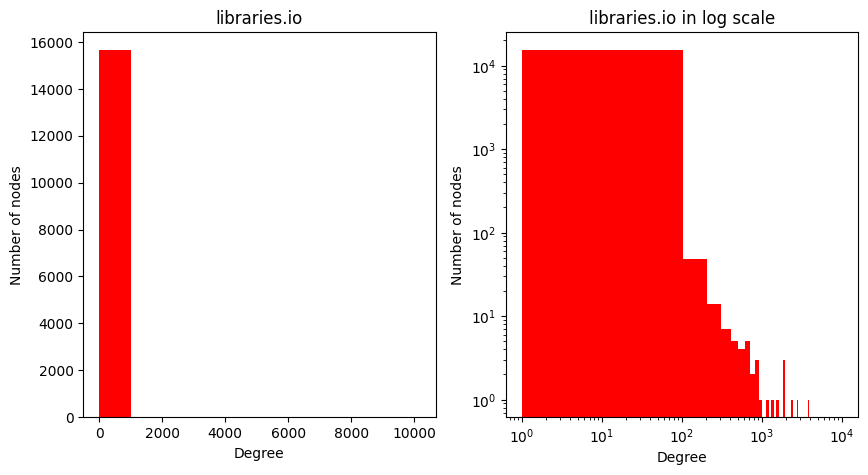

In [20]:
plot_degree_distribution(librariesio_G, 'libraries.io', "red")

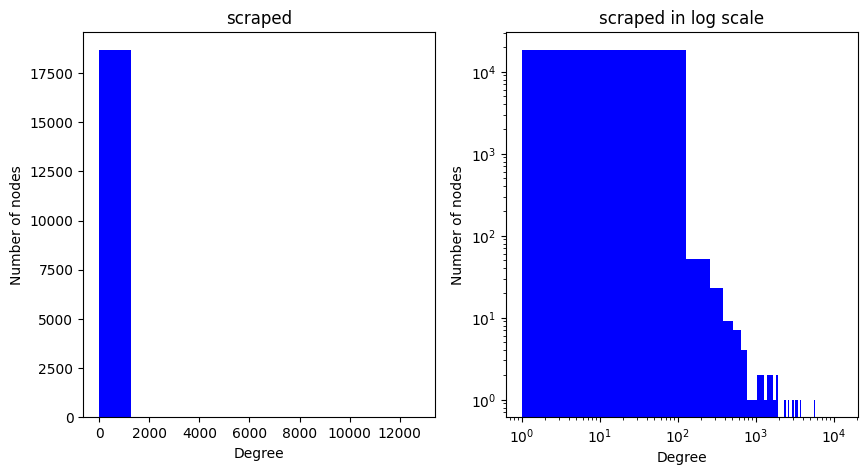

In [21]:
plot_degree_distribution(scraped_G, 'scraped', "blue")

It can indeed be observed that there has been an increase in the average degree of the network during this evolution.

In [22]:
analyze_network_degree(librariesio_G)

Average degree of the network:
9.740780980379625 

Top 10 most connected nodes (in-degree):
[('R', 10174), ('stats', 3834), ('methods', 2778), ('utils', 2393), ('Rcpp', 1878), ('ggplot2', 1864), ('graphics', 1859), ('dplyr', 1521), ('MASS', 1368), ('grDevices', 1142)] 

Top 10 most connected nodes (out-degree):
[('CNVScope', 44), ('Seurat', 44), ('smartR', 42), ('diceR', 40), ('maGUI', 37), ('MetaIntegrator', 37), ('dartR', 37), ('fdm2id', 37), ('metacoder', 36), ('jsmodule', 36)] 

Top 10 least connected nodes (in-degree):
[('nmfem', 0), ('datafsm', 0), ('epanetReader', 0), ('ftsspec', 0), ('gmapsdistance', 0), ('learNN', 0), ('RCriteo', 0), ('profilr', 0), ('strider', 0), ('rsed', 0)] 

Top 10 least connected nodes (out-degree):
[('R', 0), ('stats', 0), ('methods', 0), ('graphics', 0), ('utils', 0), ('parallel', 0), ('magrittr', 0), ('grDevices', 0), ('ncdf4', 0), ('grid', 0)] 



In [23]:
analyze_network_degree(scraped_G)

Average degree of the network:
12.133576134111724 

Top 10 most connected nodes (in-degree):
[('R', 12783), ('stats', 5660), ('methods', 3760), ('utils', 3441), ('ggplot2', 3192), ('dplyr', 3026), ('Rcpp', 2571), ('graphics', 2381), ('magrittr', 1890), ('rlang', 1846)] 

Top 10 most connected nodes (out-degree):
[('Seurat', 50), ('immunarch', 46), ('pguIMP', 41), ('epitweetr', 40), ('MetaIntegrator', 37), ('PWFSLSmoke', 36), ('bulkAnalyseR', 36), ('iemisc', 36), ('mlmts', 35), ('numbat', 35)] 

Top 10 least connected nodes (in-degree):
[('A3', 0), ('AATtools', 0), ('ABACUS', 0), ('ABC.RAP', 0), ('ABCoptim', 0), ('ABCp2', 0), ('ABHgenotypeR', 0), ('ABPS', 0), ('ABSurvTDC', 0), ('ACA', 0)] 

Top 10 least connected nodes (out-degree):
[('R', 0), ('graphics', 0), ('stats', 0), ('utils', 0), ('grDevices', 0), ('splines', 0), ('methods', 0), ('preprocessCore', 0), ('pcaMethods', 0), ('nnls', 0)] 



We can compare other interesting metrics as well.

In [24]:
metrics_libraries = calculate_network_metrics(librariesio_G)
metrics_libraries

In-degree y Out-degree OK
Betweenness Centrality OK
Closeness Centrality OK
Clustering Coefficient OK
PageRank OK


,In-degree,Out-degree,Betweenness Centrality,Closeness Centrality,Clustering Coefficient,PageRank
R,10174,0,0.000000e+00,0.703660,0.000290,0.165389
stats,3834,0,0.000000e+00,0.355618,0.000352,0.029940
methods,2778,0,0.000000e+00,0.371824,0.000771,0.038370
utils,2393,0,0.000000e+00,0.351331,0.000727,0.026901
Rcpp,1878,3,1.290268e-05,0.236645,0.000912,0.019954
ggplot2,1864,15,2.754094e-04,0.120806,0.001431,0.007204
graphics,1859,0,0.000000e+00,0.253467,0.000564,0.014063
dplyr,1521,12,7.670652e-05,0.097357,0.002036,0.005013
MASS,1368,1,7.831216e-07,0.155962,0.000923,0.008579
grDevices,1142,0,0.000000e+00,0.218443,0.001048,0.007858


In [25]:
metrics_scraped = calculate_network_metrics(scraped_G)
metrics_scraped

In-degree y Out-degree OK
Betweenness Centrality OK
Closeness Centrality OK
Clustering Coefficient OK
PageRank OK


,In-degree,Out-degree,Betweenness Centrality,Closeness Centrality,Clustering Coefficient,PageRank
R,12783,0,0.000000e+00,0.728462,0.000309,0.129158
stats,5660,0,0.000000e+00,0.435432,0.000334,0.034959
methods,3760,0,0.000000e+00,0.439673,0.000708,0.042257
utils,3441,0,0.000000e+00,0.429760,0.000739,0.039216
ggplot2,3192,16,2.471850e-04,0.171104,0.000955,0.008872
dplyr,3026,14,8.628122e-05,0.158485,0.001233,0.007130
Rcpp,2571,2,8.152448e-06,0.230190,0.000425,0.018258
graphics,2381,0,0.000000e+00,0.319058,0.000577,0.015597
magrittr,1890,1,3.033488e-07,0.214629,0.001910,0.006998
rlang,1846,2,1.829594e-06,0.236759,0.002904,0.010000


**We visualize the statistics of the degree of the selected packages for the networks**

In [63]:
def compare_network_stats(stats1, stats2, metric, tit1, tit2):
    plt.figure(figsize=(15, 10))

    # Graph 1: stat of the 10 most connected nodes
    plt.subplot(3, 1, 1)
    plt.bar(stats1[metric].index[:10], stats1[metric].values[:10], color='red')
    plt.title(f'Top {len(stats1)} {metric} of {tit1}\'s nodes')
    plt.xlabel('Node')
    for i, v in enumerate(stats1[metric].values[:10]):
        plt.text(i, v + 0.01, str(v), color='black', ha='center')
        
    plt.grid(axis='y', alpha=0.75)
    
    # Graph 2: stat of the 10 most connected nodes
    plt.subplot(3, 1, 2)
    plt.bar(stats2[metric].index[:10], stats2[metric].values[:10], color='blue')
    plt.title(f'Top {len(stats2)} {metric} of {tit2}\'s nodes')
    plt.xlabel('Node')
    for i, v in enumerate(stats2[metric].values[:10]):
        plt.text(i, v + 0.01, str(v), color='black', ha='center')
    plt.grid(axis='y', alpha=0.75)
            
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

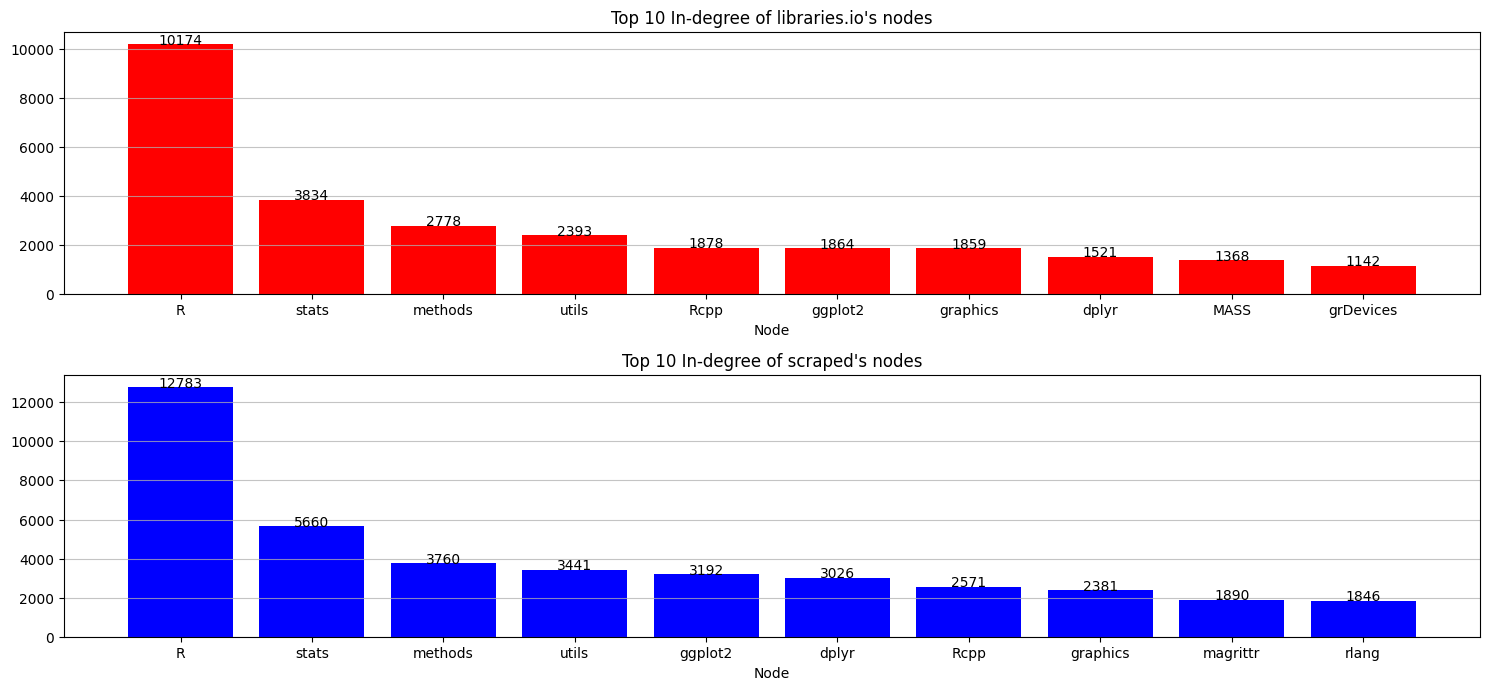

In [64]:
compare_network_stats(metrics_libraries, metrics_scraped, 'In-degree', 'libraries.io', 'scraped')

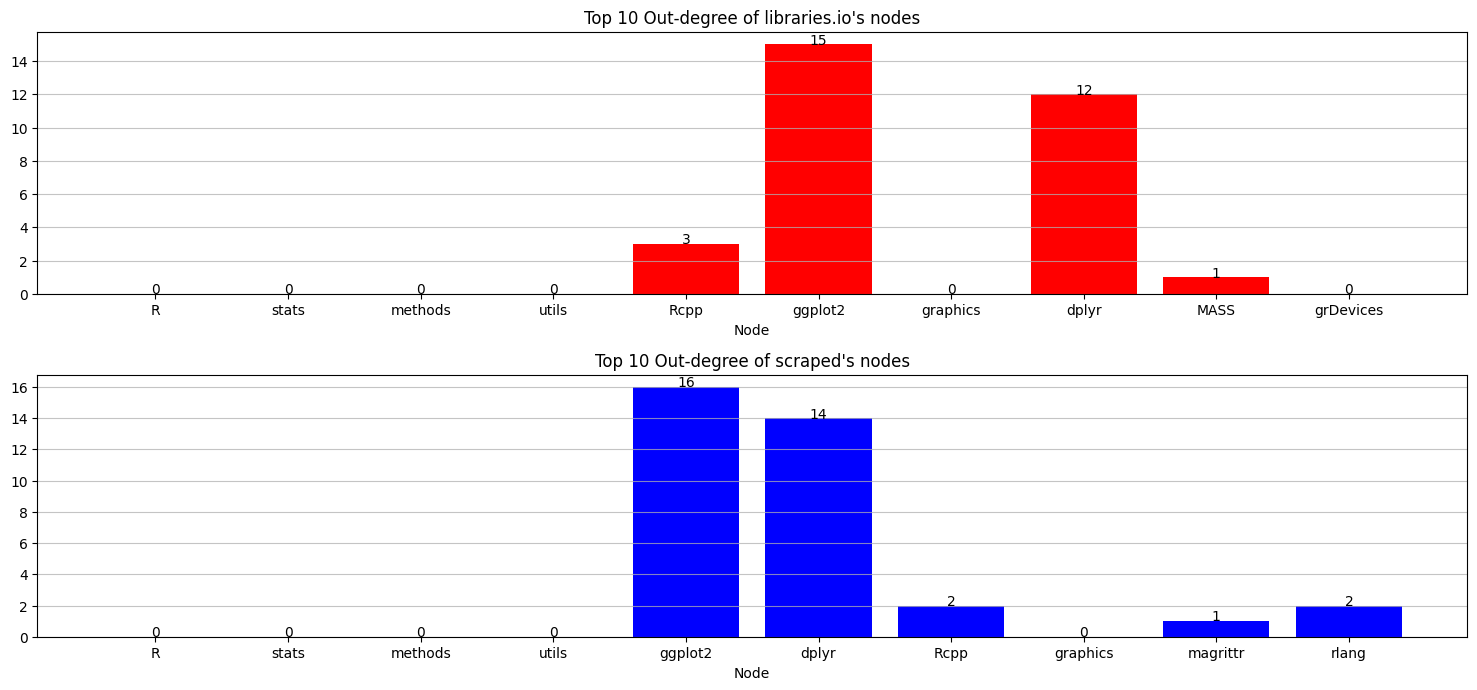

In [65]:
compare_network_stats(metrics_libraries, metrics_scraped, 'Out-degree', 'libraries.io', 'scraped')


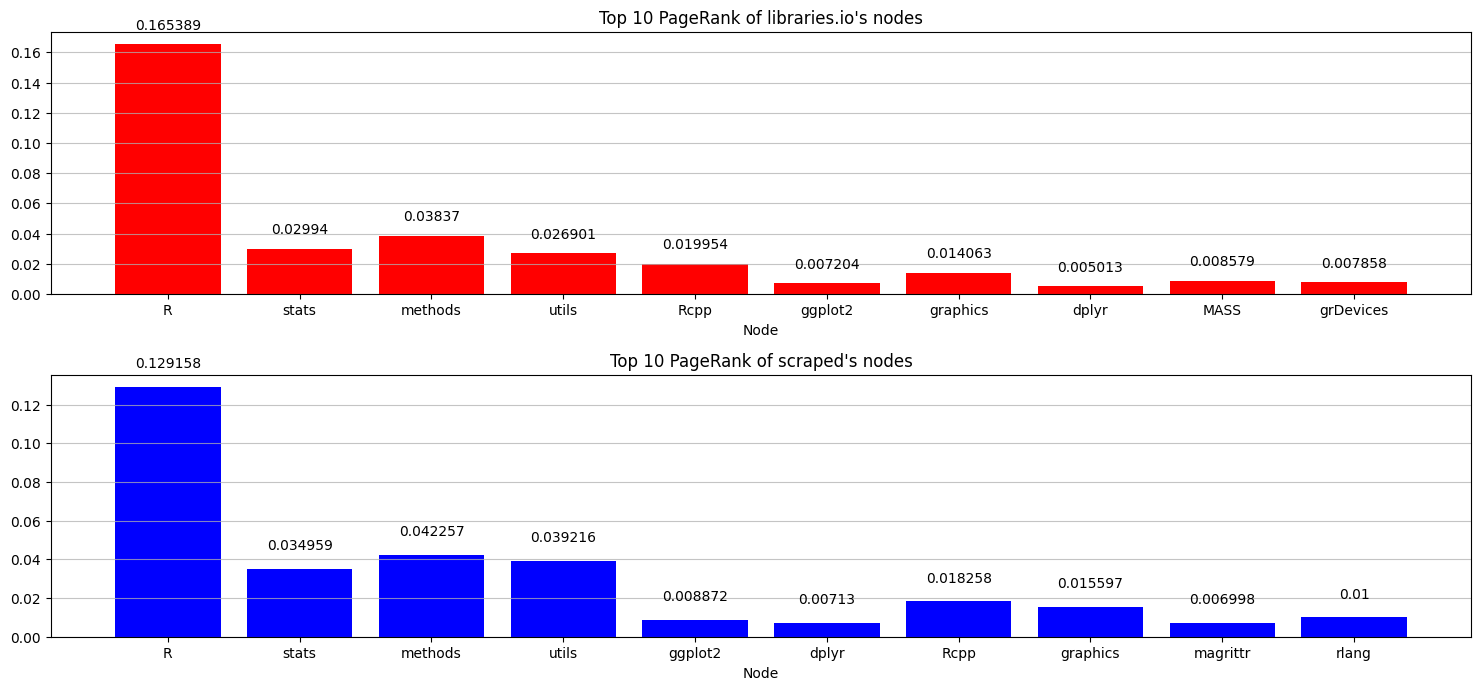

In [66]:
compare_network_stats(metrics_libraries.round(6), metrics_scraped.round(6), 'PageRank', 'libraries.io', 'scraped')

**Draw network**

To visualize a portion of the network, we will process the nodes to remove some of them and achieve a cleaner visualization.

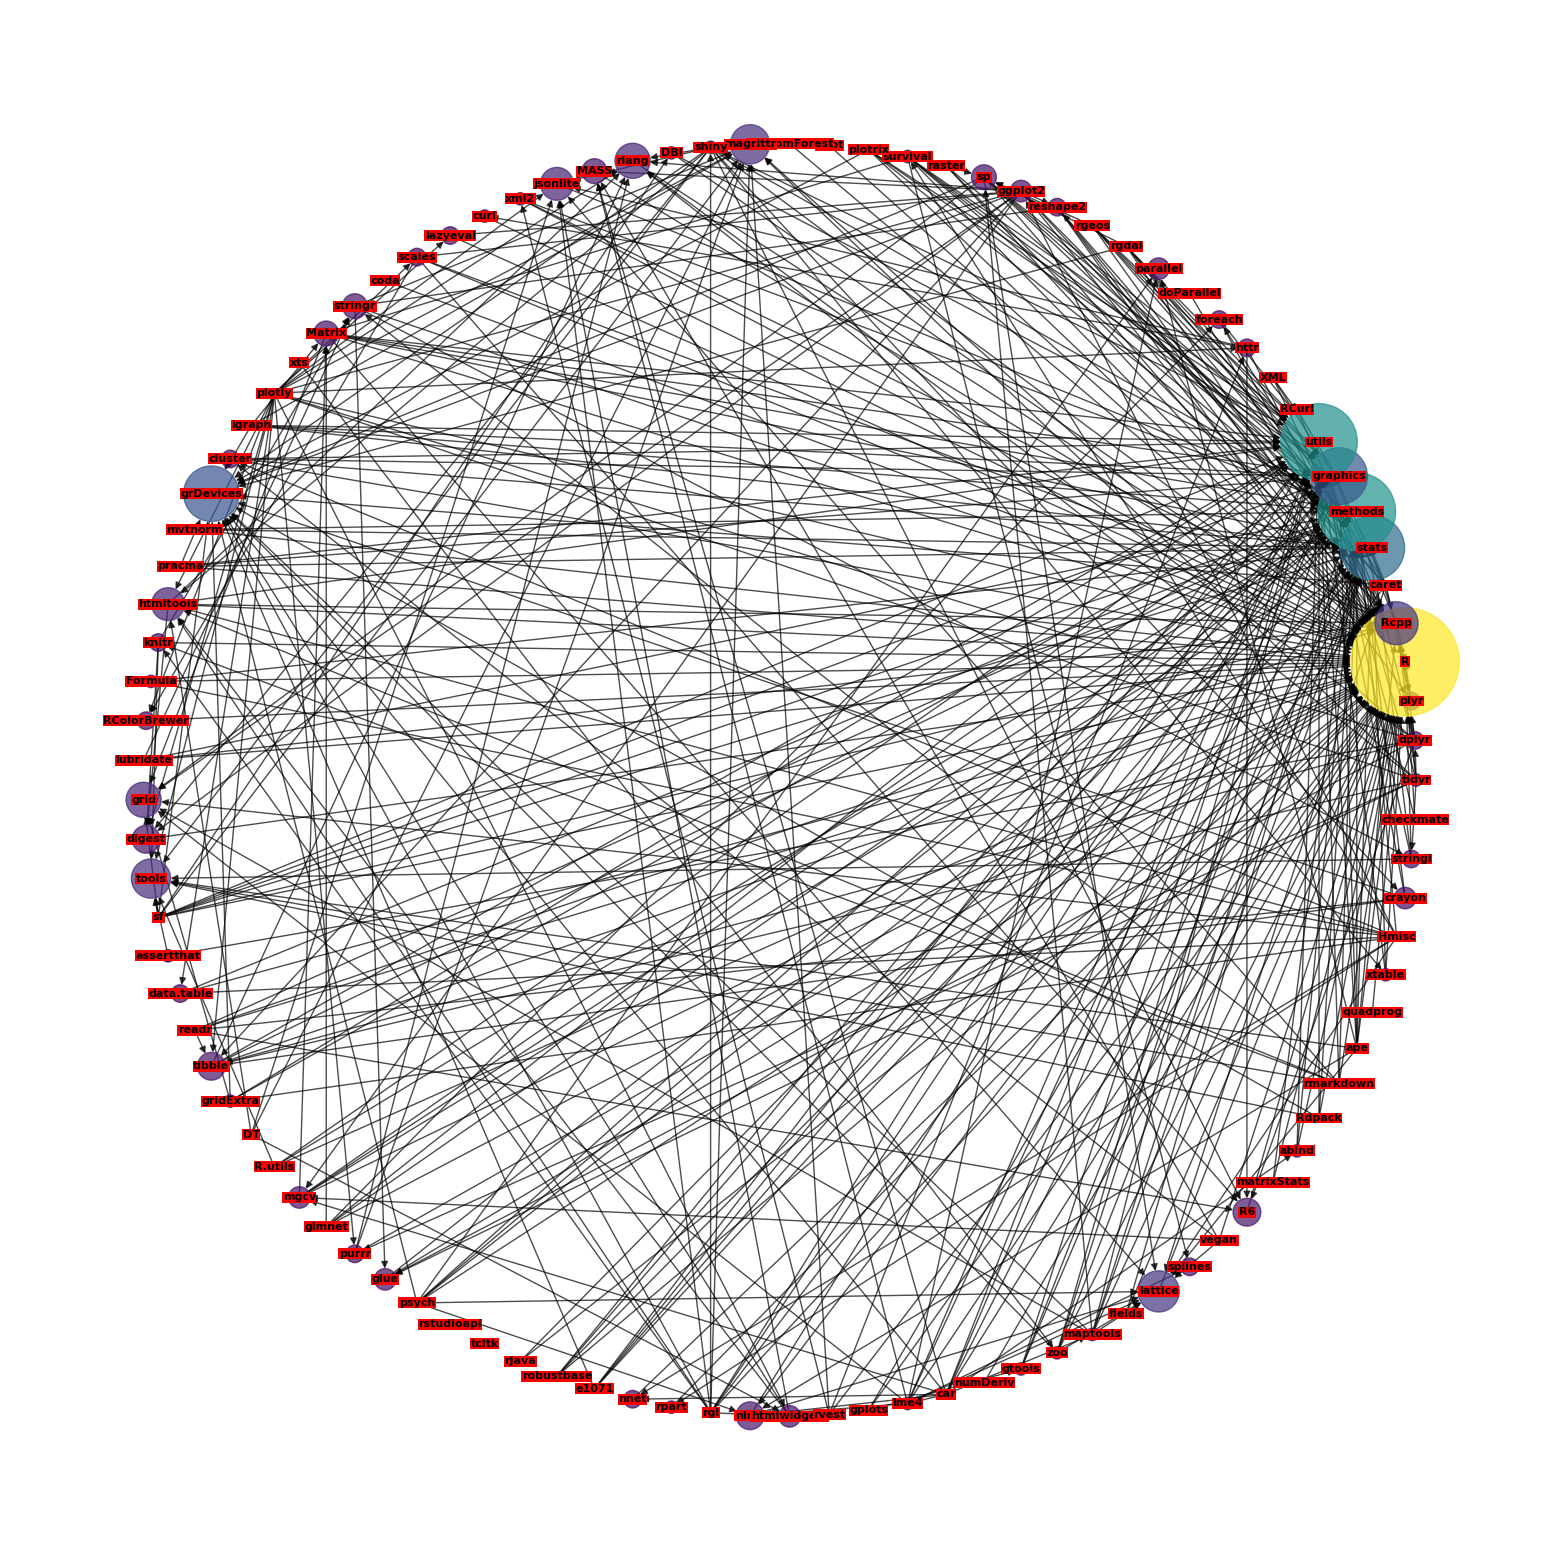

In [67]:
# Remove nodes with degree < 100
filtered_librariesio_G = librariesio_G.copy()
filtered_librariesio_G.remove_nodes_from([node for node, degree in librariesio_G.degree() if degree < 100])

# Draw libraries.io graph
draw_networkx_graph(filtered_librariesio_G, layout='circular', size=(20,20))

We can visualize the underlying network for a single package (dependency network of that package) given a certain depth.

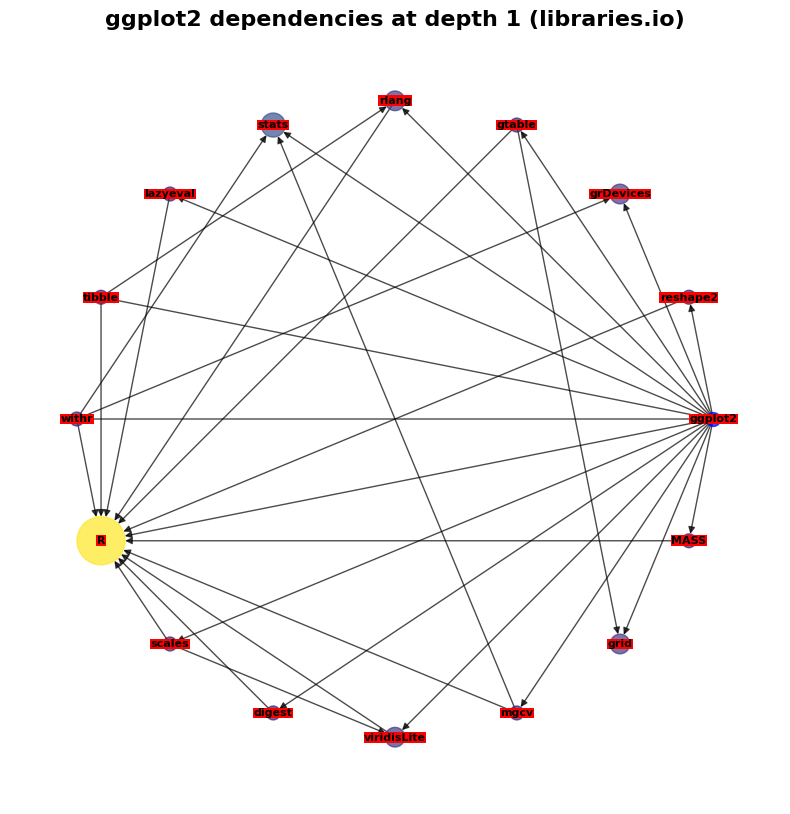

In-degree y Out-degree OK
Betweenness Centrality OK
Closeness Centrality OK
Clustering Coefficient OK
PageRank OK


,In-degree,Out-degree,Betweenness Centrality,Closeness Centrality,Clustering Coefficient,PageRank
ggplot2,0,15,0.0,0.000000,0.080952,0.036372
R,12,0,0.0,0.800000,0.098485,0.338442
withr,1,3,0.0,0.066667,0.250000,0.038434
gtable,1,2,0.0,0.066667,0.333333,0.038434
rlang,2,1,0.0,0.133333,0.500000,0.054768
stats,3,0,0.0,0.200000,0.333333,0.065658
tibble,1,2,0.0,0.066667,0.500000,0.038434
scales,1,2,0.0,0.066667,0.500000,0.038434
viridisLite,2,1,0.0,0.133333,0.500000,0.054768
mgcv,1,2,0.0,0.066667,0.333333,0.038434


In [68]:
libraries_sub_G = draw_package_deep_network(
    librariesio_G, 'ggplot2', 1, size=(10, 10), layout='circular', title='ggplot2 dependencies at depth 1 (libraries.io)'
)
calculate_network_metrics(libraries_sub_G)

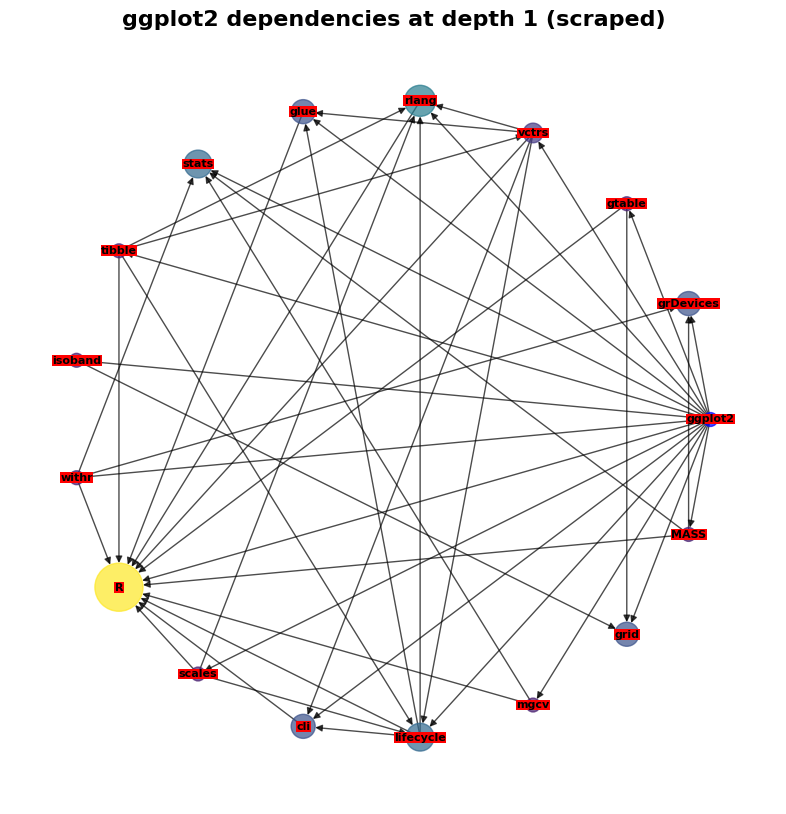

In-degree y Out-degree OK
Betweenness Centrality OK
Closeness Centrality OK
Clustering Coefficient OK
PageRank OK


,In-degree,Out-degree,Betweenness Centrality,Closeness Centrality,Clustering Coefficient,PageRank
ggplot2,0,16,0.000000,0.000000,0.125000,0.031869
R,12,0,0.000000,0.750000,0.174242,0.265120
lifecycle,4,4,0.012500,0.250000,0.339286,0.057120
vctrs,2,5,0.004167,0.125000,0.380952,0.040693
rlang,5,1,0.000000,0.312500,0.433333,0.069258
tibble,1,4,0.000000,0.062500,0.500000,0.033562
glue,3,1,0.000000,0.223214,0.500000,0.052617
stats,4,0,0.000000,0.250000,0.250000,0.066843
withr,1,3,0.000000,0.062500,0.250000,0.033562
scales,1,3,0.000000,0.062500,0.500000,0.033562


In [69]:
gplot_scraped_G = draw_package_deep_network(scraped_G, 'ggplot2', 1, size=(10, 10), layout='circular', title='ggplot2 dependencies at depth 1 (scraped)')
calculate_network_metrics(gplot_scraped_G)

We will represent the dependency network of the package "mixtools".

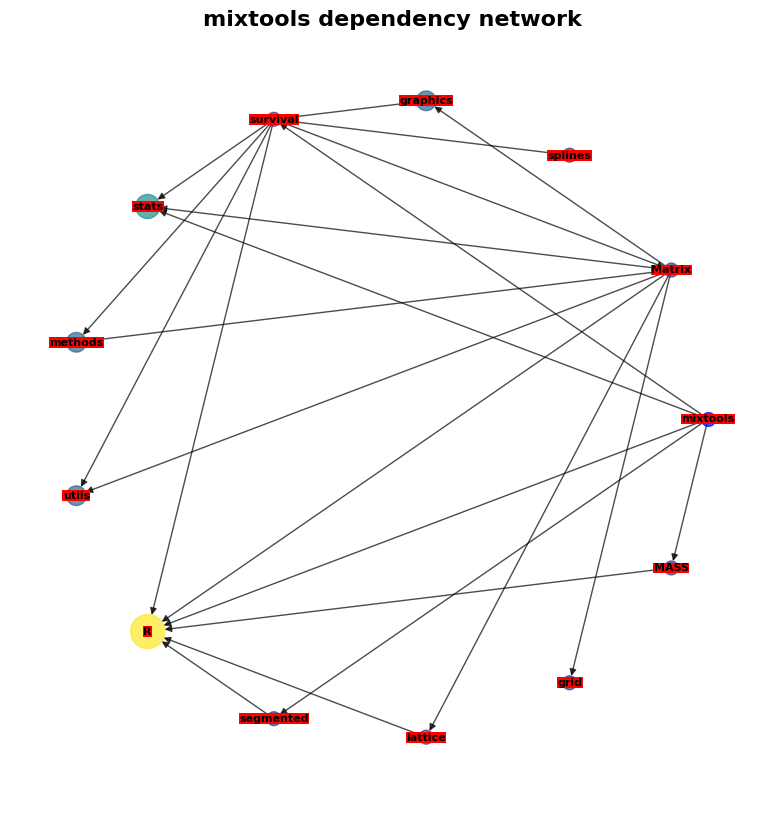

In [70]:
mixtools_librariesio_G = draw_package_deep_network(librariesio_G, 'mixtools', 10, size=(10, 10), layout='circular', title='mixtools dependency network')
